# 1. Optimizing Hyperparameters

## Introduction

To explain Optimizing Hyperparameter we are going to again use the same dataset that we have used in our previous GWP, i.e. a simple BTC Price Movement Classification to predict whether a cryptocurrency's price (e.g., Bitcoin) will move up(1) or down(0) based on historical price data and technical indicators.

This time we will use Randomforest classifier model as a baseline model then to evaluate model performance on unseen data using a Simple Cross-Validation, after that to optimize the hyperparameters we will use 3 major method:



*   Grid Search CV
*   Random Search CV
*   Bayesian Optimization

After that we will compare the results of all these methods using multiple metrices:

    accuracy_score
    classification_report
    confusion_matrix
    f1_score
    precision_score
    recall_score
    roc_auc_score
    log_loss

Furthermore all the necessary explanation and interpreatation will be provided in the report with this colab notebook.




Installing necessary data sources and computations api's

In [76]:
!pip install yfinance
!pip install pandas_ta

In [77]:
!pip install scikit-optimize

importing necessary libraries for computations

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import random
import pandas_ta as ta
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV


from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    log_loss
)


## Data Preprocessing and Feature Engineering

Downloading 5 years of daily OHLCV data og BTC-USD from yahoo finance Api

In [79]:
# Gathering BTC data

Start = '2019-01-01'
End = '2024-01-01'
df = yf.download('BTC-USD', start=Start, end=End).dropna()

[*********************100%***********************]  1 of 1 completed


In [80]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824
...,...,...,...,...,...,...
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055


calculating all the important tecnical indicators to our data frame like Returns, SMA, RSI, MACD as part of our Feature engineering.

In [81]:
df['Returns'] = df['Adj Close'].pct_change()
df['10_SMA'] = df['Close'].rolling(window=10).mean()
df['50_SMA'] = df['Close'].rolling(window=50).mean()
df['RSI'] = ta.rsi(df['Close'])
macd_df = df.ta.macd(close='Close', fast=12, slow=26, signal=9, append=True)
df['MACD'] = macd_df['MACD_12_26_9']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

Making a data of complete dataframe for further analysis

In [82]:
df_main = df.copy()

In [83]:
df_main

,Open,High,Low,Close,Adj Close,Volume,Returns,10_SMA,50_SMA,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD,Signal_Line
Date,,,,,,,,,,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836,0.025989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219,-0.027050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467,0.005467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824,-0.003246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032,0.021694,43274.542969,40039.379844,57.563288,945.599611,-195.627117,1141.226728,945.599611,1141.226728
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014,-0.018760,43274.974609,40178.831406,52.971739,841.965503,-239.408980,1081.374483,841.965503,1081.374483
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055,-0.012397,43257.862109,40286.956953,50.176936,709.019835,-297.883718,1006.903553,709.019835,1006.903553


Building a strategy to calculate up and down of BTC using the main dataframe, it will help use to create our traget variable.



*   if bulish condition is met then target value will be 1(up)
*   and if not then the target value will be 0(down)



In [84]:
df_main['Next_Day_Close'] = df_main['Close'].shift(-1)
df_main['Bullish_Condition'] = ((df_main['10_SMA'] > df_main['50_SMA']) &
                             (df_main['RSI'] < 70) &
                             (df_main['MACD'] > df_main['Signal_Line'])).astype(int)


df_main['Target'] = np.where((df_main['Next_Day_Close'] > df_main['Close']) & (df_main['Bullish_Condition'] == 1), 1, 0)


Checking the total value counts of ups and downs using target variable.

,count
Target,
0,1684
1,142


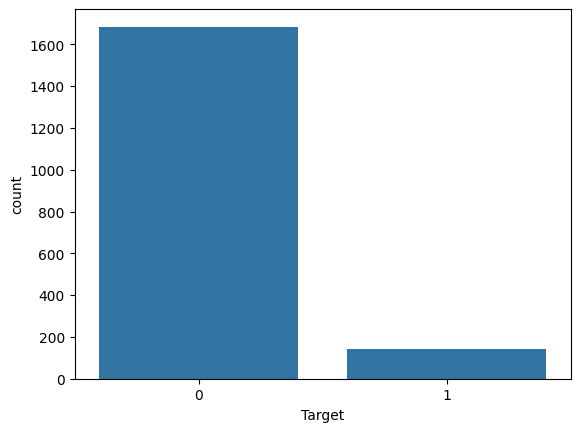

In [85]:
sns.countplot(x = "Target", data = df_main)
df_main.loc[:,"Target"].value_counts()

In [86]:
df_main.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns',
       '10_SMA', '50_SMA', 'RSI', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'MACD', 'Signal_Line', 'Next_Day_Close',
       'Bullish_Condition', 'Target'],
      dtype='object')

we have also visualized the target varible of ups and down and we can see the how scatterd are they our goal is to classify them using SVM.


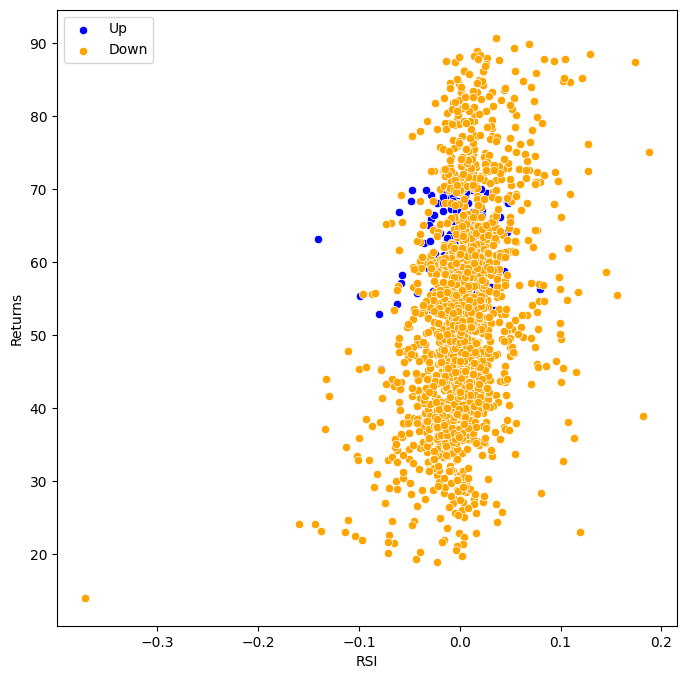

In [87]:
# Second Visual
Up = df_main[df_main.Target == 1]
Down = df_main[df_main.Target == 0]

plt.figure(figsize = (8,8))
plt.scatter(Up.Returns, Up.RSI, color = "blue", label = "Up", linewidths=0.5 ,edgecolors="white")
plt.scatter(Down.Returns, Down.RSI, color = "orange", label = "Down", linewidths=0.5, edgecolors="white")
plt.xlabel("RSI")
plt.ylabel("Returns")
plt.legend()
plt.show()

here we have made the final copy of our preprocessed data for running the learning algorithm.

In [88]:
df_rf = df_main.copy()

In [89]:
df_rf

,Open,High,Low,Close,Adj Close,Volume,Returns,10_SMA,50_SMA,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD,Signal_Line,Next_Day_Close,Bullish_Condition,Target
Date,,,,,,,,,,,,,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3943.409424,0,0
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836,0.025989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3836.741211,0,0
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219,-0.027050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3857.717529,0,0
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467,0.005467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3845.194580,0,0
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824,-0.003246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4076.632568,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032,0.021694,43274.542969,40039.379844,57.563288,945.599611,-195.627117,1141.226728,945.599611,1141.226728,42627.855469,0,0
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014,-0.018760,43274.974609,40178.831406,52.971739,841.965503,-239.408980,1081.374483,841.965503,1081.374483,42099.402344,0,0
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055,-0.012397,43257.862109,40286.956953,50.176936,709.019835,-297.883718,1006.903553,709.019835,1006.903553,42156.902344,0,0


Here we have divided our data in two forms where in x_data we drop our target variable and in y_data we will only include Target values i.e. 0's and 1's.


In [90]:
# x_data
x_data = df_rf.drop(["Target"], axis = 1)

#y_data
y_data = df_rf.Target.values

In [91]:
x_data

,Open,High,Low,Close,Adj Close,Volume,Returns,10_SMA,50_SMA,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD,Signal_Line,Next_Day_Close,Bullish_Condition
Date,,,,,,,,,,,,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3943.409424,0
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836,0.025989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3836.741211,0
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219,-0.027050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3857.717529,0
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467,0.005467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3845.194580,0
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824,-0.003246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4076.632568,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032,0.021694,43274.542969,40039.379844,57.563288,945.599611,-195.627117,1141.226728,945.599611,1141.226728,42627.855469,0
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014,-0.018760,43274.974609,40178.831406,52.971739,841.965503,-239.408980,1081.374483,841.965503,1081.374483,42099.402344,0
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055,-0.012397,43257.862109,40286.956953,50.176936,709.019835,-297.883718,1006.903553,709.019835,1006.903553,42156.902344,0


In [92]:
y_data


array([0, 0, 0, ..., 0, 0, 0])

before furthur analysis we have to normalize the data for that we are using MinMax Scaler to tranform our data, but we can also see there were some missing data due to our feature engineering we are going to take care of that here using interpolation technique we have used a linear interpolation method to fill the missing data.

In [93]:
scaler = MinMaxScaler()


x_data = scaler.fit_transform(x_data)

original_columns = df_rf.drop(["Target"], axis=1).columns


x_data = pd.DataFrame(x_data, columns=original_columns).interpolate(method='linear', limit_direction='both', axis=0)

x_data

,Open,High,Low,Close,Adj Close,Volume,Returns,10_SMA,50_SMA,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD,Signal_Line,Next_Day_Close,Bullish_Condition
0,0.005383,0.006471,0.005020,0.006920,0.006920,0.000000,0.711217,0.007462,0.000049,0.317768,0.479357,0.566829,0.483933,0.479357,0.484149,0.008477,0.0
1,0.006981,0.007956,0.006769,0.008477,0.008477,0.002656,0.711217,0.007462,0.000049,0.317768,0.479357,0.566829,0.483933,0.479357,0.484149,0.006815,0.0
2,0.008257,0.007768,0.006909,0.006815,0.006815,0.000594,0.616363,0.007462,0.000049,0.317768,0.479357,0.566829,0.483933,0.479357,0.484149,0.007141,0.0
3,0.006714,0.006701,0.006236,0.007141,0.007141,0.001511,0.674516,0.007462,0.000049,0.317768,0.479357,0.566829,0.483933,0.479357,0.484149,0.006946,0.0
4,0.007024,0.007297,0.007078,0.006946,0.006946,0.002347,0.658933,0.007462,0.000049,0.317768,0.479357,0.566829,0.483933,0.479357,0.484149,0.010553,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,0.609791,0.615884,0.615588,0.624046,0.624046,0.060398,0.703537,0.650150,0.636627,0.567372,0.580888,0.499658,0.623064,0.580888,0.623064,0.611345,0.0
1822,0.624596,0.617745,0.617985,0.611345,0.611345,0.053853,0.631188,0.650157,0.639068,0.507460,0.570852,0.485064,0.616381,0.570852,0.616381,0.603109,0.0
1823,0.611290,0.607334,0.603785,0.603109,0.603109,0.062531,0.642568,0.649877,0.640960,0.470993,0.557979,0.465571,0.608066,0.557979,0.608066,0.604005,0.0
1824,0.603139,0.599069,0.605883,0.604005,0.604005,0.033723,0.667181,0.647435,0.642656,0.474988,0.547555,0.456722,0.599010,0.547555,0.599010,0.605693,0.0


## Baseline model

We are first starting with a baseline model which is a Random Forest model with default hyperparametrs.

In [94]:
X = x_data
y = y_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [95]:
# Baseline Model (Random Forest Classifier with default hyperparameters)
baseline_model = RandomForestClassifier()
baseline_model.fit(X_train, y_train)


RandomForestClassifier()

In [96]:
# Predict on test set
y_pred_baseline = baseline_model.predict(X_test)


In [97]:
# Evaluate baseline model
print("Baseline Model Accuracy:", accuracy_score(y_test, y_pred_baseline))
print("Baseline Model Classification Report:\n", classification_report(y_test, y_pred_baseline))


Baseline Model Accuracy: 0.9562841530054644
Baseline Model Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       338
           1       0.77      0.61      0.68        28

    accuracy                           0.96       366
   macro avg       0.87      0.80      0.83       366
weighted avg       0.95      0.96      0.95       366



We evaluated the model and got a accuracy of 92%, we can also see see confusion matrix plot below.

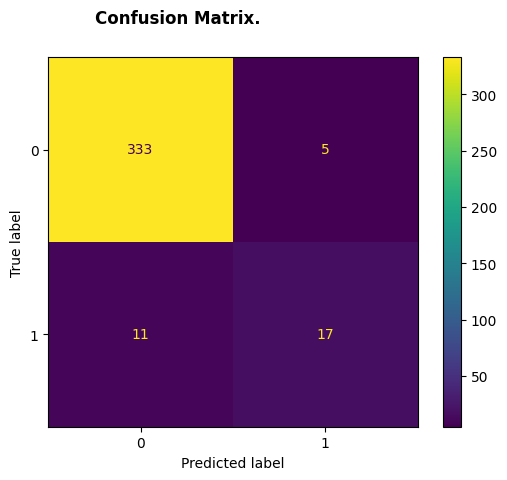

In [98]:
from sklearn.metrics import ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay.from_estimator(baseline_model, X_test, y_test)
plt.suptitle(
    "Confusion Matrix.", fontweight="bold", horizontalalignment="right"
)
plt.show()

## Cross Validation

We then used cross validation for the validation strategies on how model is performing on unseen data and we can see the accuracy is approx 94%.

In [99]:
cv_results = cross_validate(baseline_model, X_test, y_test)
scores = cv_results["test_score"]
print(
    f"Accuracy score via cross-validation:\n"
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

Accuracy score via cross-validation:
0.921 ± 0.020


In [100]:
print("learning rate default value", baseline_model.get_params()["n_estimators"])
print("max_leaf_nodes default value", baseline_model.get_params()["max_leaf_nodes"])

learning rate default value 100
max_leaf_nodes default value None


In [101]:
baseline_model.set_params(n_estimators=200)
baseline_model.set_params(max_leaf_nodes=20)
cv_results = cross_validate(baseline_model, X_test, y_test)
scores = cv_results["test_score"]
print(
    f"Model accuracy score with cross-validation:\n"
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

Model accuracy score with cross-validation:
0.921 ± 0.020


## Grid Search

To improve the Accuracy we will start with hyperparamater tuning using Grid search CV which exhaustively searching through a specified subset of hyperparameters. For each combination, the model is trained and evaluated. The combination with the best performance is selected.


In [102]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    #'criterion': ['gini', 'entropy']
}

# Grid Search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate optimized model
optimized_model = grid_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test)
print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred_optimized))
print("Optimized Model Classification Report:\n", classification_report(y_test, y_pred_optimized))


Best Parameters: {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
Best Score: 0.9349315068493151
Optimized Model Accuracy: 0.9426229508196722
Optimized Model Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       338
           1       0.64      0.57      0.60        28

    accuracy                           0.94       366
   macro avg       0.80      0.77      0.79       366
weighted avg       0.94      0.94      0.94       366



After running this hypermeter optimization technique with best parameter according to grid search ({'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}) our accuracy improved a little bit to 94.6%, we can alsoo see some improvement in the consuion matrix.

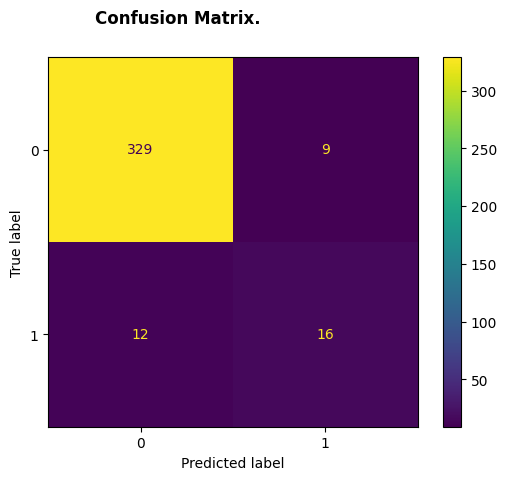

In [103]:
_ = ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test)
plt.suptitle(
    "Confusion Matrix.", fontweight="bold", horizontalalignment="right"
)
plt.show()

## Random Search

Next we used another optimization technique which is Random search in which random Search samples hyperparameters is used from a distribution.

In [104]:
# Random Search
random_search = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=5, n_iter=10)
random_search.fit(X_train, y_train)
y_pred_random = random_search.best_estimator_.predict(X_test)

# Print best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Evaluate optimized model
Random_Search_model = random_search.best_estimator_
y_pred_randomize = Random_Search_model.predict(X_test)
print("Randomize Model Accuracy:", accuracy_score(y_test, y_pred_randomize))
print("Randomize Model Classification Report:\n", classification_report(y_test, y_pred_randomize))


Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 15}
Best Score: 0.9301369863013699
Randomize Model Accuracy: 0.9480874316939891
Randomize Model Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       338
           1       0.67      0.64      0.65        28

    accuracy                           0.95       366
   macro avg       0.82      0.81      0.81       366
weighted avg       0.95      0.95      0.95       366



After running this hypermeter optimization technique with best parameter according to grid search ({'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 15}) our accuracy is not improved much it's 94.4% although this is avery minor difference, we can also see some improvement in the consuion matrix.

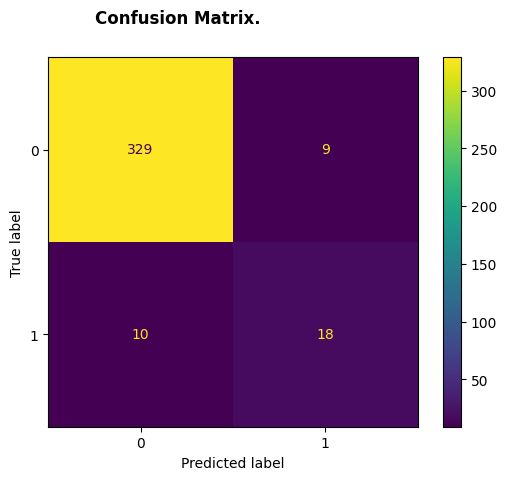

In [105]:
_ = ConfusionMatrixDisplay.from_estimator(random_search, X_test, y_test)
plt.suptitle(
    "Confusion Matrix.", fontweight="bold", horizontalalignment="right"
)
plt.show()

## Bayesian Optimization

At last we used a probabilistic model i.e. Bayesian Optimization which uses a probabilistic model to predict the performance of different hyperparameter settings. It iteratively updates the model to focus on promising regions of the hyperparameter space.


In [106]:
# Bayesian Optimization
bayes_search = BayesSearchCV(RandomForestClassifier(), param_grid, cv=5, n_iter=10)
bayes_search.fit(X_train, y_train)
y_pred_bayes = bayes_search.best_estimator_.predict(X_test)


# Evaluate optimized model
bayes_search_model = bayes_search.best_estimator_
y_pred_bayes = bayes_search_model.predict(X_test)
print("Bayesian Model Accuracy:", accuracy_score(y_test, y_pred_bayes))
print("Bayesian Model Classification Report:\n", classification_report(y_test, y_pred_bayes))


Bayesian Model Accuracy: 0.9508196721311475
Bayesian Model Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       338
           1       0.71      0.61      0.65        28

    accuracy                           0.95       366
   macro avg       0.84      0.79      0.81       366
weighted avg       0.95      0.95      0.95       366



this model have performed the worst in comparision of all model it has given us accuracy of just 92%.

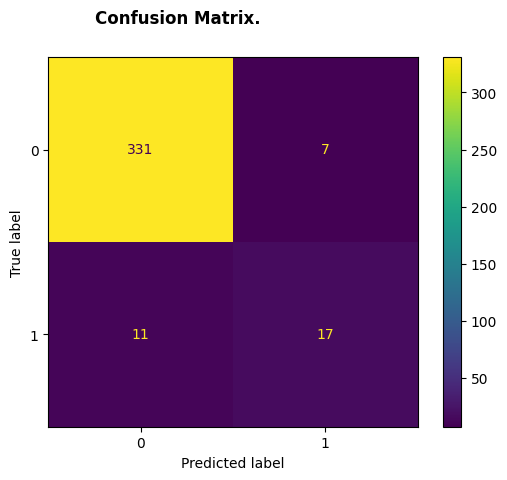

In [107]:
_ = ConfusionMatrixDisplay.from_estimator(bayes_search, X_test, y_test)
plt.suptitle(
    "Confusion Matrix.", fontweight="bold", horizontalalignment="right"
)
plt.show()

## Metrics Comparision

Here we have taken a list of metrices and compred all the model you can see the result below in the data frame and a more detailed report and interpration is provided in the repot with this colab notebook.

In [108]:
metrics = {
    "balanced_accuracy": "Accuracy",
    "roc_auc": "AUC",
    "neg_log_loss": "Log Loss",
    "f1_weighted": "F1",
    "precision_weighted": "Precision",
    "recall_weighted": "Recall",
}

# Calculate metrics for baseline and optimized models
baseline_metrics = {
    "Model": "Baseline",
    "Accuracy": accuracy_score(y_test, y_pred_baseline),
    "AUC": roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:, 1]),
    "Log Loss": log_loss(y_test, baseline_model.predict_proba(X_test)[:, 1]),
    "F1": f1_score(y_test, y_pred_baseline, average='weighted'),
    "Precision": precision_score(y_test, y_pred_baseline, average='weighted'),
    "Recall": recall_score(y_test, y_pred_baseline, average='weighted'),
}

grid_metrics = {
    "Model": "Grid Search",
    "Accuracy": accuracy_score(y_test, y_pred_optimized),
    "AUC": roc_auc_score(y_test, grid_search.best_estimator_.predict_proba(X_test)[:, 1]),
    "Log Loss": log_loss(y_test, grid_search.best_estimator_.predict_proba(X_test)[:, 1]),
    "F1": f1_score(y_test, y_pred_optimized, average='weighted'),
    "Precision": precision_score(y_test, y_pred_optimized, average='weighted'),
    "Recall": recall_score(y_test, y_pred_optimized, average='weighted'),
}

random_metrics = {
    "Model": "Random Search",
    "Accuracy": accuracy_score(y_test, y_pred_randomize),
    "AUC": roc_auc_score(y_test, random_search.best_estimator_.predict_proba(X_test)[:, 1]),
    "Log Loss": log_loss(y_test, random_search.best_estimator_.predict_proba(X_test)[:, 1]),
    "F1": f1_score(y_test, y_pred_randomize, average='weighted'),
    "Precision": precision_score(y_test, y_pred_randomize, average='weighted'),
    "Recall": recall_score(y_test, y_pred_randomize, average='weighted'),
}

bayes_metrics = {
    "Model": "Bayesian Optimization",
    "Accuracy": accuracy_score(y_test, y_pred_bayes),
    "AUC": roc_auc_score(y_test, bayes_search.best_estimator_.predict_proba(X_test)[:, 1]),
    "Log Loss": log_loss(y_test, bayes_search.best_estimator_.predict_proba(X_test)[:, 1]),
    "F1": f1_score(y_test, y_pred_bayes, average='weighted'),
    "Precision": precision_score(y_test, y_pred_bayes, average='weighted'),
    "Recall": recall_score(y_test, y_pred_bayes, average='weighted'),
}


In [109]:
# Create DataFrame
metrics_df = pd.DataFrame([baseline_metrics, grid_metrics, random_metrics, bayes_metrics])

# Print DataFrame
metrics_df


,Model,Accuracy,AUC,Log Loss,F1,Precision,Recall
0,Baseline,0.956284,0.982143,0.083969,0.953854,0.953083,0.956284
1,Grid Search,0.942623,0.977177,0.098193,0.941126,0.939961,0.942623
2,Random Search,0.948087,0.981720,0.082517,0.947654,0.947257,0.948087
3,Bayesian Optimization,0.950820,0.983094,0.084295,0.949073,0.947984,0.950820


No Skill: ROC AUC=0.500
Random forest Clasifier: ROC AUC=0.982
Grid Search: ROC AUC=0.977
Random Search: ROC AUC=0.982
Bayes Optimization: ROC AUC=0.983


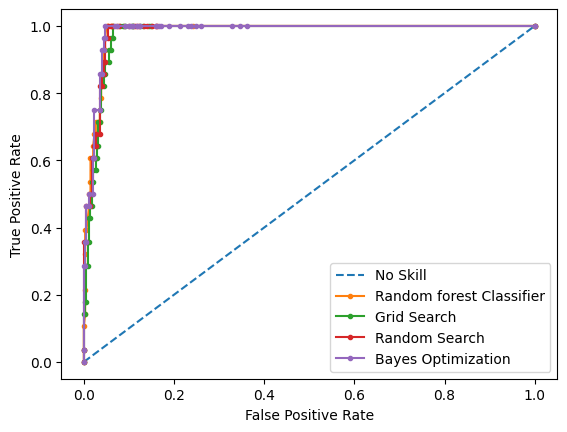

In [110]:
# Obtain the probabilities
rf_clf_tmp = baseline_model.predict_proba(X_test)
preds_prob_rf = rf_clf_tmp[:, 1]

rf_grid = grid_search.best_estimator_.predict_proba(X_test)
preds_prob_grid = rf_grid[:, 1]

rf_random = random_search.best_estimator_.predict_proba(X_test)
preds_prob_random = rf_random[:, 1]

rf_bayes = bayes_search.best_estimator_.predict_proba(X_test)
preds_prob_bayes = rf_bayes[:, 1]

# generate a no skill or random guess prediction
ns_probs = [0 for _ in range(len(y_test))]
# calculate roc curves
# random
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

# Random Forest
rf_fpr, rf_tpr, _ = roc_curve(y_test, preds_prob_rf)

# Grid Search
gd_fpr, gd_tpr, _ = roc_curve(y_test, preds_prob_grid)

# random Search
rd_fpr, rd_tpr, _ = roc_curve(y_test, preds_prob_random)

# Bayes Search
by_fpr, by_tpr, _ = roc_curve(y_test, preds_prob_bayes)

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)  # random guess
rf_auc = roc_auc_score(y_test, preds_prob_rf)  # tree classifier
grid_auc = roc_auc_score(y_test, preds_prob_grid)  # tree classifier
rd_auc = roc_auc_score(y_test, preds_prob_random)  # tree classifier
by_auc = roc_auc_score(y_test, preds_prob_bayes)  # tree classifier


# summarize scores
print("No Skill: ROC AUC=%.3f" % (ns_auc))
print("Random forest Clasifier: ROC AUC=%.3f" % (rf_auc))
print("Grid Search: ROC AUC=%.3f" % (grid_auc))
print("Random Search: ROC AUC=%.3f" % (rd_auc))
print("Bayes Optimization: ROC AUC=%.3f" % (by_auc))

plt.plot(ns_fpr, ns_tpr, linestyle="--", label="No Skill")
plt.plot(rf_fpr, rf_tpr, marker=".", label="Random forest Classifier")
plt.plot(gd_fpr, gd_tpr, marker=".", label="Grid Search")
plt.plot(rd_fpr, rd_tpr, marker=".", label="Random Search")
plt.plot(by_fpr, by_tpr, marker=".", label="Bayes Optimization")

# axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# show the legend
plt.legend()
# show the plot
plt.show()

# 2. Optimizing the Bias-Variance Tradeoff

## Introduction

To explain Optimizing the Bias-Variance Tradeoff, we are going to again use the same dataset that we have used in our previous GWP, i.e. a simple BTC Price Movement Classification to predict whether a cryptocurrency's price (e.g., Bitcoin) will move up(1) or down(0) based on historical price data and technical indicators.

In SVM, the C parameter determines the penalty for misclassifications and the kernal needs to be tuned for optimizing performance based on linearity of data.

We will do
*   Grid Search CV
to look for the optimal values of C and kernel using GridSearchCV

After that we will compare the results of all these methods using multiple metrices:

    accuracy_score
    classification_report
    f1_score
    precision_score
    recall_score
    roc_auc_score
    log_loss

Furthermore all the necessary explanation and interpreatation will be provided in the report with this colab notebook.




Installing necessary data sources and computations api's

In [35]:
!pip install yfinance
!pip install pandas_ta

In [36]:
!pip install scikit-optimize

importing necessary libraries for computations

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import random
import pandas_ta as ta
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV


from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    log_loss
)


## Data Preprocessing and Feature Engineering

Downloading 5 years of daily OHLCV data og BTC-USD from yahoo finance Api

In [38]:
# Gathering BTC data

Start = '2019-01-01'
End = '2024-01-01'
df = yf.download('BTC-USD', start=Start, end=End).dropna()

[*********************100%***********************]  1 of 1 completed


In [39]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824
...,...,...,...,...,...,...
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055


calculating all the important tecnical indicators to our data frame like Returns, SMA, RSI, MACD as part of our Feature engineering.

In [40]:
df['Returns'] = df['Adj Close'].pct_change()
df['10_SMA'] = df['Close'].rolling(window=10).mean()
df['50_SMA'] = df['Close'].rolling(window=50).mean()
df['RSI'] = ta.rsi(df['Close'])
macd_df = df.ta.macd(close='Close', fast=12, slow=26, signal=9, append=True)
df['MACD'] = macd_df['MACD_12_26_9']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

Making a data of complete dataframe for further analysis

In [41]:
df_main = df.copy()

In [42]:
df_main

,Open,High,Low,Close,Adj Close,Volume,Returns,10_SMA,50_SMA,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD,Signal_Line
Date,,,,,,,,,,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836,0.025989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219,-0.027050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467,0.005467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824,-0.003246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032,0.021694,43274.542969,40039.379844,57.563288,945.599611,-195.627117,1141.226728,945.599611,1141.226728
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014,-0.018760,43274.974609,40178.831406,52.971739,841.965503,-239.408980,1081.374483,841.965503,1081.374483
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055,-0.012397,43257.862109,40286.956953,50.176936,709.019835,-297.883718,1006.903553,709.019835,1006.903553


Building a strategy to calculate up and down of BTC using the main dataframe, it will help use to create our traget variable.



*   if bulish condition is met then target value will be 1(up)
*   and if not then the target value will be 0(down)



In [43]:
df_main['Next_Day_Close'] = df_main['Close'].shift(-1)
df_main['Bullish_Condition'] = ((df_main['10_SMA'] > df_main['50_SMA']) &
                             (df_main['RSI'] < 70) &
                             (df_main['MACD'] > df_main['Signal_Line'])).astype(int)


df_main['Target'] = np.where((df_main['Next_Day_Close'] > df_main['Close']) & (df_main['Bullish_Condition'] == 1), 1, 0)


Checking the total value counts of ups and downs using target variable.

,count
Target,
0,1684
1,142


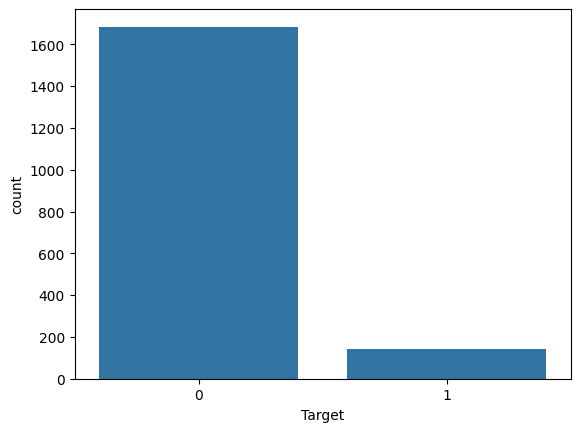

In [44]:
sns.countplot(x = "Target", data = df_main)
df_main.loc[:,"Target"].value_counts()

In [45]:
df_main.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns',
       '10_SMA', '50_SMA', 'RSI', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'MACD', 'Signal_Line', 'Next_Day_Close',
       'Bullish_Condition', 'Target'],
      dtype='object')

we have also visualized the target varible of ups and down and we can see the how scatterd are they our goal is to classify them using SVM.


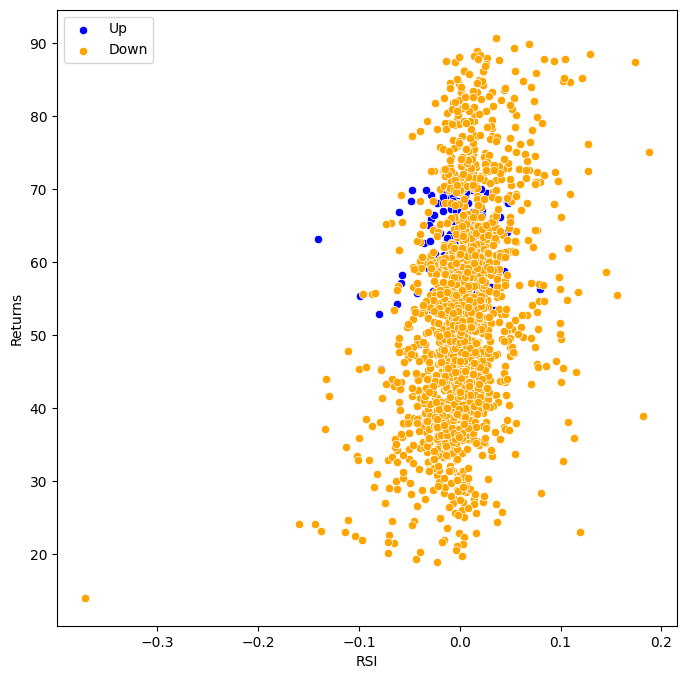

In [46]:
# Second Visual
Up = df_main[df_main.Target == 1]
Down = df_main[df_main.Target == 0]

plt.figure(figsize = (8,8))
plt.scatter(Up.Returns, Up.RSI, color = "blue", label = "Up", linewidths=0.5 ,edgecolors="white")
plt.scatter(Down.Returns, Down.RSI, color = "orange", label = "Down", linewidths=0.5, edgecolors="white")
plt.xlabel("RSI")
plt.ylabel("Returns")
plt.legend()
plt.show()

here we have made the final copy of our preprocessed data for running the learning algorithm.

In [47]:
df_rf = df_main.copy()

In [48]:
df_rf

,Open,High,Low,Close,Adj Close,Volume,Returns,10_SMA,50_SMA,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD,Signal_Line,Next_Day_Close,Bullish_Condition,Target
Date,,,,,,,,,,,,,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3943.409424,0,0
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836,0.025989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3836.741211,0,0
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219,-0.027050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3857.717529,0,0
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467,0.005467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3845.194580,0,0
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824,-0.003246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4076.632568,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032,0.021694,43274.542969,40039.379844,57.563288,945.599611,-195.627117,1141.226728,945.599611,1141.226728,42627.855469,0,0
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014,-0.018760,43274.974609,40178.831406,52.971739,841.965503,-239.408980,1081.374483,841.965503,1081.374483,42099.402344,0,0
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055,-0.012397,43257.862109,40286.956953,50.176936,709.019835,-297.883718,1006.903553,709.019835,1006.903553,42156.902344,0,0


Here we have divided our data in two forms where in x_data we drop our target variable and in y_data we will only include Target values i.e. 0's and 1's.


In [49]:
# x_data
x_data = df_rf.drop(["Target"], axis = 1)

#y_data
y_data = df_rf.Target.values

In [50]:
x_data

,Open,High,Low,Close,Adj Close,Volume,Returns,10_SMA,50_SMA,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD,Signal_Line,Next_Day_Close,Bullish_Condition
Date,,,,,,,,,,,,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3943.409424,0
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836,0.025989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3836.741211,0
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219,-0.027050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3857.717529,0
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467,0.005467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3845.194580,0
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824,-0.003246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4076.632568,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032,0.021694,43274.542969,40039.379844,57.563288,945.599611,-195.627117,1141.226728,945.599611,1141.226728,42627.855469,0
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014,-0.018760,43274.974609,40178.831406,52.971739,841.965503,-239.408980,1081.374483,841.965503,1081.374483,42099.402344,0
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055,-0.012397,43257.862109,40286.956953,50.176936,709.019835,-297.883718,1006.903553,709.019835,1006.903553,42156.902344,0


In [51]:
y_data


array([0, 0, 0, ..., 0, 0, 0])

before furthur analysis we have to normalize the data for that we are using MinMax Scaler to tranform our data, but we can also see there were some missing data due to our feature engineering we are going to take care of that here using interpolation technique we have used a linear interpolation method to fill the missing data.

In [52]:
scaler = MinMaxScaler()


x_data = scaler.fit_transform(x_data)

original_columns = df_rf.drop(["Target"], axis=1).columns


x_data = pd.DataFrame(x_data, columns=original_columns).interpolate(method='linear', limit_direction='both', axis=0)

x_data

,Open,High,Low,Close,Adj Close,Volume,Returns,10_SMA,50_SMA,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD,Signal_Line,Next_Day_Close,Bullish_Condition
0,0.005383,0.006471,0.005020,0.006920,0.006920,0.000000,0.711217,0.007462,0.000049,0.317768,0.479357,0.566829,0.483933,0.479357,0.484149,0.008477,0.0
1,0.006981,0.007956,0.006769,0.008477,0.008477,0.002656,0.711217,0.007462,0.000049,0.317768,0.479357,0.566829,0.483933,0.479357,0.484149,0.006815,0.0
2,0.008257,0.007768,0.006909,0.006815,0.006815,0.000594,0.616363,0.007462,0.000049,0.317768,0.479357,0.566829,0.483933,0.479357,0.484149,0.007141,0.0
3,0.006714,0.006701,0.006236,0.007141,0.007141,0.001511,0.674516,0.007462,0.000049,0.317768,0.479357,0.566829,0.483933,0.479357,0.484149,0.006946,0.0
4,0.007024,0.007297,0.007078,0.006946,0.006946,0.002347,0.658933,0.007462,0.000049,0.317768,0.479357,0.566829,0.483933,0.479357,0.484149,0.010553,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,0.609791,0.615884,0.615588,0.624046,0.624046,0.060398,0.703537,0.650150,0.636627,0.567372,0.580888,0.499658,0.623064,0.580888,0.623064,0.611345,0.0
1822,0.624596,0.617745,0.617985,0.611345,0.611345,0.053853,0.631188,0.650157,0.639068,0.507460,0.570852,0.485064,0.616381,0.570852,0.616381,0.603109,0.0
1823,0.611290,0.607334,0.603785,0.603109,0.603109,0.062531,0.642568,0.649877,0.640960,0.470993,0.557979,0.465571,0.608066,0.557979,0.608066,0.604005,0.0
1824,0.603139,0.599069,0.605883,0.604005,0.604005,0.033723,0.667181,0.647435,0.642656,0.474988,0.547555,0.456722,0.599010,0.547555,0.599010,0.605693,0.0


## Baseline model

In [53]:
X = x_data
y = y_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [54]:
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']  # Relevant for non-linear kernels
}

In [55]:
svm = SVC(probability=True)  # Enable probability predictions for AUC and Log Loss
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']})

In [56]:
print("Best SVM Parameters:", grid_search_svm.best_params_)

Best SVM Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}


In [57]:
y_pred_svm = grid_search_svm.best_estimator_.predict(X_test)

In [58]:
# Evaluate baseline model
print("SVM Model Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Model Accuracy: 0.9836065573770492
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       341
           1       0.83      0.96      0.89        25

    accuracy                           0.98       366
   macro avg       0.91      0.97      0.94       366
weighted avg       0.99      0.98      0.98       366



## Cross Validation

In [59]:
cv_results_svm = cross_validate(grid_search_svm.best_estimator_, X_test, y_test)
scores_svm = cv_results_svm["test_score"]
print(f"SVM Accuracy score via cross-validation: {scores_svm.mean():.3f} ± {scores_svm.std():.3f}")

SVM Accuracy score via cross-validation: 0.967 ± 0.014


## Metrics Comparision

In [60]:
svm_metrics = {
    "Model": "SVM",
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "AUC": roc_auc_score(y_test, grid_search_svm.best_estimator_.predict_proba(X_test)[:, 1]),
    "Log Loss": log_loss(y_test, grid_search_svm.best_estimator_.predict_proba(X_test)[:, 1]),
    "F1": f1_score(y_test, y_pred_svm, average='weighted'),
    "Precision": precision_score(y_test, y_pred_svm, average='weighted'),
    "Recall": recall_score(y_test, y_pred_svm, average='weighted'),
}

metrics_df_svm = pd.DataFrame([svm_metrics])
metrics_df_svm

,Model,Accuracy,AUC,Log Loss,F1,Precision,Recall
0,SVM,0.983607,0.998123,0.0419,0.984165,0.985458,0.983607


## Conclusion

C parameter tuning that we just did will control the bias-variance tradeoff, making it ideal for balancing model complexity.
The performance of SVM can be evaluated against Random Forest results using the same metrics by comparing it with Part 1 Optimizing Hyperparameters


# 3. Applying ensemble learning - Bagging

## Introduction

To demonstrate how bagging is used to combine models, we will use data from the prevoius GWP 2  predicting NVDA stock price movements given the stock returns on IBM, Amazon, Google, Cisco, Apple and Microsoft. We will represent instances where the returns on NVDA stocks were higher than 2% as 1 and were the retuns are lower than 2% will be represented as 0.


The baseline model will be a random forest classifier and we will ensemble 10 decision trees.

## Data Preprocessing and Feature Engineering

In [61]:
!pip install pandas_ta

In [62]:
#import libraries
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score,classification_report,confusion_matrix,f1_score,precision_score,recall_score,
                             roc_auc_score)


In [63]:
#import data
data_df = yf.download(["AAPL","AMZN","CSCO","GOOGL","IBM","MSFT","NVDA"],
                      start="2010-01-01", end="2021-12-31")["Adj Close"]
data_df["Date"] = pd.to_datetime(data_df.index)
data_df["Date"] = data_df["Date"].dt.date
data_df.set_index("Date",inplace=True)
data_df.head(3)

[*********************100%***********************]  7 of 7 completed


Ticker,AAPL,AMZN,CSCO,GOOGL,IBM,MSFT,NVDA
Date,,,,,,,
2010-01-04,6.454506,6.6950,16.475376,15.645692,75.353798,23.347317,0.423952
2010-01-05,6.465665,6.7345,16.401964,15.576794,74.443527,23.354864,0.430143
2010-01-06,6.362820,6.6125,16.295202,15.184123,73.959938,23.211536,0.432894


In [64]:
# calculate returns
returns_df = data_df.pct_change().dropna()
returns_df.head()

Ticker,AAPL,AMZN,CSCO,GOOGL,IBM,MSFT,NVDA
Date,,,,,,,
2010-01-05,0.001729,0.005900,-0.004456,-0.004404,-0.012080,0.000323,0.014602
2010-01-06,-0.015906,-0.018116,-0.006509,-0.025209,-0.006496,-0.006137,0.006397
2010-01-07,-0.001849,-0.017013,0.004505,-0.023280,-0.003462,-0.010400,-0.019597
2010-01-08,0.006649,0.027077,0.005300,0.013331,0.010035,0.006897,0.002161
2010-01-11,-0.008822,-0.024041,-0.002839,-0.001512,-0.010470,-0.012720,-0.014016


In [65]:
#creating technical indicators
#SMA ratio
returns_df["SMA_5"] = returns_df["NVDA"].rolling(5).mean()
returns_df["SMA_15"] = returns_df["NVDA"].rolling(15).mean()
returns_df["SMA_ratio"] = returns_df["SMA_15"] / returns_df["SMA_5"]

#RSI
returns_df["RSI"] = ta.rsi(returns_df["NVDA"])

#Rate of change
returns_df["RC"] = returns_df["NVDA"].pct_change(periods=15)

#replace infinite values with nan
returns_df.replace([np.inf, -np.inf], np.nan, inplace=True)

returns_df.dropna(inplace=True)
returns_df.head()

Ticker,AAPL,AMZN,CSCO,GOOGL,IBM,MSFT,NVDA,SMA_5,SMA_15,SMA_ratio,RSI,RC
Date,,,,,,,,,,,,
2010-01-27,0.009420,0.027369,0.010916,-0.000590,0.004612,0.005763,0.027143,-0.007994,-0.007719,0.965632,54.751903,0.858824
2010-01-28,-0.041321,0.026721,-0.027214,-0.014407,-0.020423,-0.017189,-0.033634,-0.011149,-0.010387,0.931715,45.103125,-6.258119
2010-01-29,-0.036279,-0.004919,-0.002220,-0.008142,-0.010990,-0.033608,-0.043505,-0.012929,-0.011981,0.926702,43.754383,1.220005
2010-02-01,0.013902,-0.052149,0.011571,0.005812,0.018629,0.008162,0.076673,-0.000997,-0.007014,7.038191,59.595233,34.486836
2010-02-02,0.005803,-0.006309,0.012759,-0.003565,0.006898,0.001760,0.010259,0.007387,-0.005395,-0.730351,51.040252,-1.731966


In [66]:
#drop columns that are not needed
returns_df.drop(
    ["SMA_5", "SMA_15"],
    axis=1,
    inplace=True,
)

In [67]:
# specify the feaatures
# AAPL, AMZN, CSCO, GOOGL, IBM, MSFT, SMA_ratio, RSI, RC

feats = ["AAPL","AMZN","CSCO","GOOGL","IBM","MSFT","SMA_ratio","RSI","RC"]

# specify the target
target = "NVDA"

In [68]:
# split the data into X and y
X = returns_df[feats]
y = np.where(returns_df[target] > 0.02, 1, 0)
print(X.shape, y.shape)

(2982, 9) (2982,)


## Baseline Model

In [69]:
# splitting the data into training and test sets
# using 80/20 split
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=0)

# creating the random forest classifier as the bagging classifier
bagmodel = RandomForestClassifier(n_estimators=10, random_state = 42)

# fitting the model
bagmodel.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [70]:
print("Accuracy on train set: %0.4f" % (bagmodel.score(X_train, y_train)))
print("Accuracy on test set: %0.4f" % (bagmodel.score(X_test, y_test)))


Accuracy on train set: 0.9958
Accuracy on test set: 0.9229


## Grid Search for Best Hyperparameters


In [71]:
# defining parameter range
param_grid = {
    "n_estimators": [10, 20, 30, 40, 50],
    "max_depth": [2, 3, 4, 5, 6],
    "min_samples_split": [2, 4, 8, 16, 32],
    "min_samples_leaf": [1, 2, 4, 8, 16]
}


grid = GridSearchCV(
    RandomForestClassifier(random_state=8), param_grid, refit=True, verbose=3, cv=3
)

# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 3 folds for each of 625 candidates, totalling 1875 fits
[CV 1/3] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.882 total time=   0.0s
[CV 2/3] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.860 total time=   0.0s
[CV 3/3] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.878 total time=   0.0s
[CV 1/3] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=0.872 total time=   0.0s
[CV 2/3] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=0.859 total time=   0.0s
[CV 3/3] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=0.874 total time=   0.1s
[CV 1/3] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=30;, score=0.882 total time=   0.1s
[CV 2/3] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=30;, score=0.878 total time=   0.1s
[CV 3/3]

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 4, 8, 16],
                         'min_samples_split': [2, 4, 8, 16, 32],
                         'n_estimators': [10, 20, 30, 40, 50]},
             verbose=3)

In [72]:
# Print best parameters and score
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

#create a tuned FR classifier
bagmodel_tuned = RandomForestClassifier(
    n_estimators=10,
    max_depth=grid.best_params_["max_depth"],
    min_samples_split=grid.best_params_["min_samples_split"],
    random_state=8,
)

bagmodel_tuned.fit(X_train, y_train)

# Evaluate optimized model
y_pred_optimized = bagmodel_tuned.predict(X_test)
print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred_optimized))
print("Optimized Model Classification Report:\n", classification_report(y_test, y_pred_optimized))

Best Parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 20}
Best Score: 0.9303983228511531
Optimized Model Accuracy: 0.9296482412060302
Optimized Model Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       503
           1       0.78      0.78      0.78        94

    accuracy                           0.93       597
   macro avg       0.87      0.87      0.87       597
weighted avg       0.93      0.93      0.93       597



## Metrics Comparison

In [73]:
# Calculate metrics for baseline and optimized models

y_pred_baseline = bagmodel.predict(X_test)

baseline_metrics = {
    "Model": "Baseline",
    "Accuracy": accuracy_score(y_test, y_pred_baseline),
    "AUC": roc_auc_score(y_test, bagmodel.predict_proba(X_test)[:, 1]),
    "F1": f1_score(y_test, y_pred_baseline, average='weighted'),
    "Precision": precision_score(y_test, y_pred_baseline, average='weighted'),
    "Recall": recall_score(y_test, y_pred_baseline, average='weighted'),
}

grid_metrics = {
    "Model": "Grid Search",
    "Accuracy": accuracy_score(y_test, y_pred_optimized),
    "AUC": roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test)[:, 1]),
    "F1": f1_score(y_test, y_pred_optimized, average='weighted'),
    "Precision": precision_score(y_test, y_pred_optimized, average='weighted'),
    "Recall": recall_score(y_test, y_pred_optimized, average='weighted')
    }

# Create DataFrame
metrics_df_rf = pd.DataFrame([baseline_metrics, grid_metrics])

# Print DataFrame
metrics_df_rf

,Model,Accuracy,AUC,F1,Precision,Recall
0,Baseline,0.922948,0.951356,0.923597,0.924375,0.922948
1,Grid Search,0.929648,0.969037,0.929648,0.929648,0.929648


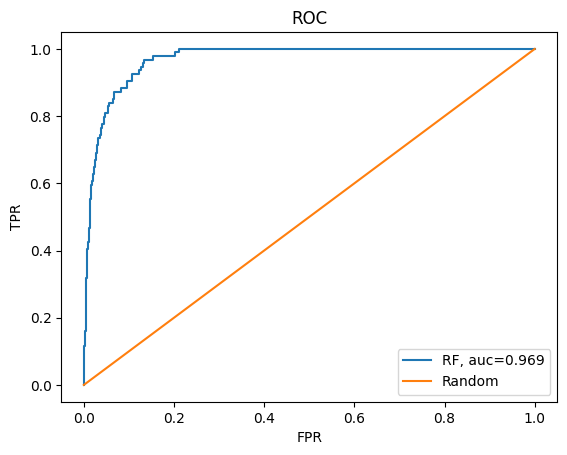

In [74]:
import matplotlib.pyplot as plt

# Performance
from sklearn.metrics import roc_auc_score, roc_curve

# predicted probabilities generated by tuned classifier
y_pred_proba = bagmodel_tuned.predict_proba(X_test)

# RF ROC dependencies
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
auc = round(roc_auc_score(y_test, y_pred_proba[:, 1]), 4)

# RF Model
plt.plot(fpr, tpr, label="RF, auc=" + str(auc))

# Random guess model
plt.plot(fpr, fpr, "-", label="Random")
plt.title("ROC")
plt.ylabel("TPR")
plt.xlabel("FPR")

plt.legend(loc=4)
plt.show()